# Initialization

In [1]:
from IPython.display import HTML

# This code bit is directly taken from this notebook: https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In this kernel, I am taking a first attempt at the Kaggle challenge [House Price: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 
The first part of the work goes into the preparation of the data and the filling of missing values. Here, I benefited strongly from [this kernel](https://www.kaggle.com/jonhar/lasso-and-xgboost-top-15) by Jonas Harnau and reused many of the ideas there. In the second part, I investigate the importance of different features using a random forest. This uses tools (and code) taught in the fast.ai course [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml). In the third part, I create an XGBoost model, a feedforward Neural Network and a Lasso Regressor and combine these for the final predictions. For the XGBoost model, I reused the parameters determined in [this](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) kernel by Serigne.

The notebook runs in a few minutes on a 2014 Macbook Pro.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from fastai.imports import *
from fastai.tabular import *
import fastaimisc
import seaborn as sns
from scipy.stats import norm
plt.style.use('seaborn-darkgrid')
np.random.seed(6)

#Turn off some annoying deprecation warnings
import warnings
warnings.warn = lambda *args, **kwargs: None
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warnings turned off.')

Deprecation warnings turned off.


First we load the take and take a first look at the data set.

In [3]:
# loading the data set and test set
df_raw = pd.read_csv('train.csv',index_col='Id')
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

To see whether the test set has a significant component (i.e., whether we are trying to predict future sales), we look at *YearSold* of the training and test sets. This is not the case.

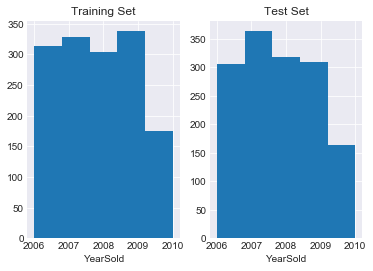

In [4]:
plt.subplot(1, 2, 1)
plt.hist(df_train.YrSold,5)
plt.title('Training Set')
plt.xlabel('YearSold')
plt.subplot(1, 2, 2)
plt.hist(df_test.YrSold,5)
plt.title('Test Set')
plt.xlabel('YearSold')
plt.show()

# Outlier Cleaning

According to Dean de Cock, the data set contains five outliers with *GrLivArea* > 4000: two large houses with accordingly high prices and three large houses with unsusually low prices (partial sales). 

In [5]:
outlierID_train = df_train[ df_train.GrLivArea > 4000].index
outlierID_test = df_test[ df_test.GrLivArea > 4000].index

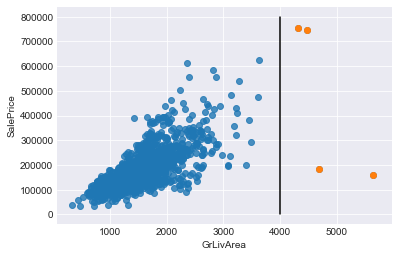

Id
2550    5095
Name: GrLivArea, dtype: int64


In [6]:
fig,ax = plt.subplots()
ax.scatter(df_train.GrLivArea,df_train.SalePrice,alpha=0.8)
ax.scatter(df_train.GrLivArea[df_train.GrLivArea>4000],df_train.SalePrice[df_raw.GrLivArea>4000])
ax.plot([4000,4000],[0,8*10**5],color='black')
plt.xlabel('GrLivArea', size=10)
plt.ylabel('SalePrice', size=10)
plt.show()

print(df_test.GrLivArea[df_test.GrLivArea>4000])

We see that the training set contains four of those houses but only two partial sales. Thus, the test set must contain the last partial sale. Later set its predicted value to the average of the two other partial sales.
For now, we record the average *SalePrice* for the partial sales and drop the outliers from the training set.

In [7]:
outlier_predicted_price = df_train.loc[(df_train.GrLivArea > 4000) & (df_train.SalePrice < 3*10**5)].SalePrice.mean()
df_train.drop(outlierID_train,inplace=True)
df_raw.drop(outlierID_train,inplace=True)

Next, we transform the dependent variable into the logarithmic domain and drop it from the training set.

In [8]:
y_target = np.log(df_train.SalePrice)
print('y_target set as log-SalePrice')
df_train.drop('SalePrice',axis=1,inplace=True)
print('Dependent variable dropped from training set.')

y_target set as log-SalePrice
Dependent variable dropped from training set.


# Missing Values

In this section, we deal with the many missing values in the data set. First,
we first fill in those missing values that actually indicate the absence of a feature. This is given in the description of the data set. We fill in the value *NotAv* for these values.

In [9]:
# Concatenate Test and Training Set
df_tot = pd.concat([df_train,df_test])
# Figure out missing values
list_missing_values = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                       'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                      'PoolQC','Fence','MiscFeature']
for val in list_missing_values:
    df_tot.fillna(value={val:'NotAv'},inplace=True)


Next, we investigate the true missing values with a bar chart.

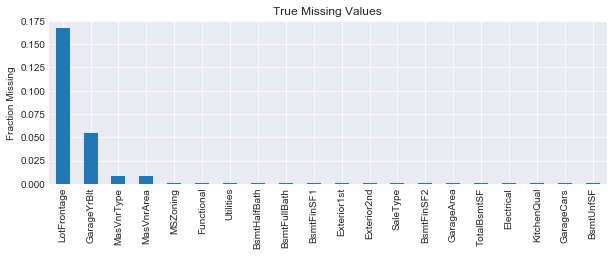

In [10]:
df_tot_missing = df_tot.isnull().mean()[df_tot.isnull().any()]
df_tot_missing.sort_values(ascending=False).plot.bar(figsize=(10,3))
plt.title('True Missing Values')
plt.ylabel('Fraction Missing')
plt.show()

We move from top to bottom. The first thing to tackle is *LotFrontage*. We guess that this is closely related to other Lot features and aim to fill in these values with a simple linear regression. Quick distribution and regression plots show that *LotFrontage* is skewed and the regression is not very good. In the logarithmic domain, the plots look much better.

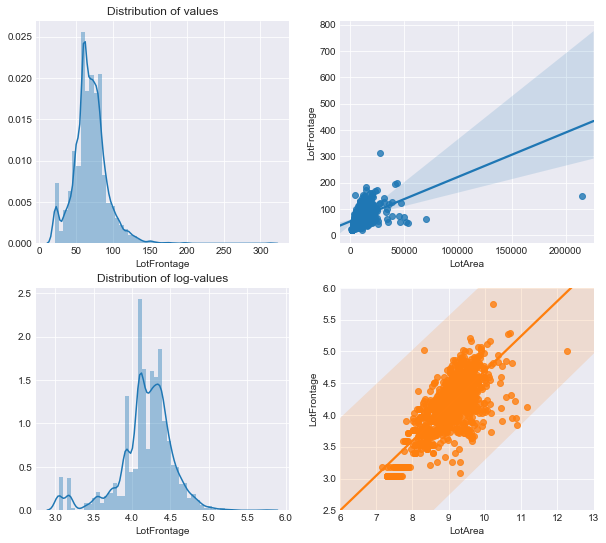

In [11]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,9))
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()],ax=ax[0][0])
ax[0][0].set_title('Distribution of values')
sns.regplot(x='LotArea',y='LotFrontage',
            data=df_tot.loc[df_tot.LotFrontage.notnull(),['LotArea', 'LotFrontage']],ax=ax[0][1])
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()].apply(np.log),ax=ax[1][0])
ax[1][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1][0].set_title('Distribution of log-values')
sns.regplot(x='LotArea',y='LotFrontage',
            data=df_tot.loc[df_tot.LotFrontage.notnull(),['LotArea', 'LotFrontage']].apply(np.log),ax=ax[1][1])
ax[1][1].set_xlim(6, 13)
ax[1][1].set_ylim(2.5, 6)

plt.show()

To fill in the values, we use *LotArea*, *LotConfig*, *Neighborhood* for the regression. The numerical features are use logarithmically and the categorical features are one-hot encoded. The regression is reasonably good with an R2 of .71. Another regression plot displays the filled values in red.

R2 of the regression: 0.71


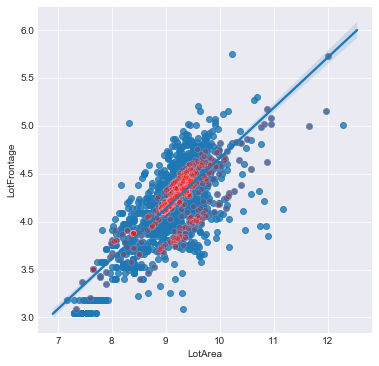

In [12]:
from sklearn.linear_model import LinearRegression
tmp = pd.get_dummies(df_tot[['LotFrontage','LotArea', 'LotConfig', 'Neighborhood']])
tmp.loc[:,['LotArea','LotFrontage']] = np.log(tmp.loc[:,['LotArea','LotFrontage']])
tmp
#display(tmp.dropna()['LotFrontage'])
#display(np.log(tmp.dropna().drop('LotArea',axis=1)))
#tmp.dropna().drop('LotFrontage', axis=1)
tmpreg = LinearRegression()
tmpreg.fit(tmp.dropna().drop('LotFrontage',axis=1),tmp.dropna()['LotFrontage'])

print('R2 of the regression: {:.2f}'.format(
    tmpreg.score(tmp.dropna().drop('LotFrontage', axis=1), tmp.dropna()['LotFrontage']))
     )
#tmp3 = tmpreg.predict(tmp.loc[tmp.isnull().any(axis=1),['LotArea']])
tmp3 = tmpreg.predict(tmp.loc[tmp.isnull().any(axis=1)].drop('LotFrontage',axis=1))
df_tot.loc[df_tot.LotFrontage.isnull(),'LotFrontage'] = np.exp(tmp3)

fig,ax = plt.subplots(figsize=(6,6))
sns.regplot(x='LotArea',y='LotFrontage',
            data=pd.concat([df_tot.loc[df_tot.LotFrontage.notnull(),'LotArea'].apply(np.log),
           df_tot.loc[df_tot.LotFrontage.notnull(),'LotFrontage'].apply(np.log)], axis=1, sort=False),ax=ax)
sns.scatterplot(x=tmp.loc[tmp.isnull().any(axis=1)]['LotArea'],y=tmp3,color='red',alpha=0.2,ax=ax)  
plt.show()

We next look at the missing values considering the different garage properties. We see that there are many missing values for *GarageYrBlt*, but only one each for *GarageCars* and *GarageArea*. The latter two actually belong to the same house. 

In [13]:
display(df_tot.loc[df_tot.GarageArea.isnull(),['GarageArea','GarageCars','GarageType','GarageYrBlt','YearBuilt']])

,GarageArea,GarageCars,GarageType,GarageYrBlt,YearBuilt
Id,,,,,
2577,NaN,NaN,Detchd,NaN,1923


This house seems to have a garage since is has *GarageType = Detchd*. There are quite a few houses in the same neighborhood with a similar age and the same garage type. We fill the missing values for GarageArea, GarageYrBlt and GarageCars with the median of those values.

In [14]:
tmp = df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars.isnull()) & (df_tot.GarageArea.isnull())].index
#display(df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']),['GarageArea','GarageType','GarageCars','GarageCond','Neighborhood','GarageYrBlt','YearBuilt','YearRemodAdd']])
df_tot.loc[tmp[0],'GarageArea'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']) & (df_tot.YearBuilt <= df_tot.loc[tmp[0],'YearBuilt']),'GarageArea'].median()
df_tot.loc[tmp[0],'GarageCars'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']) & (df_tot.YearBuilt <= df_tot.loc[tmp[0],'YearBuilt']),'GarageCars'].median()
df_tot.loc[tmp[0],'GarageYrBlt'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']) & (df_tot.YearBuilt <= df_tot.loc[tmp[0],'YearBuilt']),'GarageYrBlt'].median()
display(df_tot.loc[tmp,['GarageArea','GarageCars','GarageYrBlt']])
print('Missing vals for GarageCars and GarageArea fixed.')

,GarageArea,GarageCars,GarageYrBlt
Id,,,
2577,308.0,1.0,1922.0


Missing vals for GarageCars and GarageArea fixed.


Next, we tackle the *GarageYrBlt*. Since *GarageCars* has no missing values, we can plot the histogram for the size of the garages for the missing values.

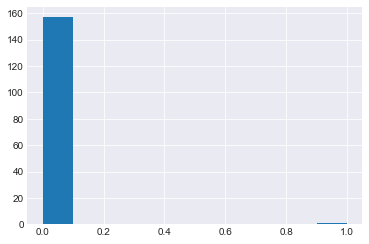

In [15]:
df_tot.loc[df_tot.GarageYrBlt.isnull(),'GarageCars'].hist()
plt.show()

Except for one house, all missing values relate to houses without a garage. For these, we simply set *GarageYrBlt* equal to zero.

In [16]:
df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars == 0),'GarageYrBlt'] = 0
print('GarageYrBlt fixed for missing garages.')

GarageYrBlt fixed for missing garages.


Next, we fix the *GarageYrBlt* for the one observation that has a Garage but is missing the *GarageYrBlt* feature.
This house was built in 1910. As a (hopefully) reasonable guess, we set its GarageYrBlt to the average value for those houses in the same neighborhood that were build before 1930 and have the same type of garage.

In [17]:
tmp = df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars > 0)].index
display(df_tot.loc[tmp[0]][['YearBuilt','MSSubClass','MSZoning','Neighborhood','GarageType','GarageCars','GarageCond']])
#[['GarageFinish','GarageCars','GarageQual','YearBuilt','YearRemodAdd']]
df_tot.loc[tmp[0],'GarageYrBlt'] = round(df_tot.loc[(df_tot.YearBuilt < 1930) & (df_tot.GarageType == 'Detchd') & (df_tot.Neighborhood == 'OldTown')]['GarageYrBlt'].mean())

display(df_tot.loc[tmp[0]][['GarageYrBlt']])

print('Missing vals for GarageYrBlt fixed.')

YearBuilt          1910
MSSubClass           60
MSZoning             RM
Neighborhood    OldTown
GarageType       Detchd
GarageCars            1
GarageCond        NotAv
Name: 2127, dtype: object

GarageYrBlt    1948
Name: 2127, dtype: object

Missing vals for GarageYrBlt fixed.


Last, we discover that there is a clear mistake in the *GarageYrBlt* data since on garage seems to have been built far away in the future. We correct this mistake and set the value equal to the value of *YearBuilt*.

In [18]:
tmp = df_tot.loc[df_tot['GarageYrBlt'] > 2100].index
df_tot.loc[tmp[0],'GarageYrBlt']  = df_tot.loc[tmp[0],'YearBuilt'] 

The next class is *MasVnrType* and *MasVnrArea*. Before considering the missing values, we do a sanity check for the remaining values since we should have *MasVnrArea* = 0 for *MasVnrType* = None.
We see that this is not always the case.

In [19]:
display(df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea > 0),['MasVnrType','MasVnrArea']])
display(df_tot.loc[(df_tot.MasVnrType != 'None') & (df_tot.MasVnrArea == 0),['MasVnrType','MasVnrArea']])

,MasVnrType,MasVnrArea
Id,,
625,None,288.0
774,None,1.0
1231,None,1.0
1301,None,344.0
1335,None,312.0
1670,None,285.0
2453,None,1.0


,MasVnrType,MasVnrArea
Id,,
689,BrkFace,0.0
1242,Stone,0.0
2320,BrkFace,0.0


We believe that for *MasVnrType* = None and *MasVnrArea* = 1, the latter area should be zero. Further, if both values are missing, we assume that no masonry veneer exists and set it to None and 0, repsectively. For the houses with  *MasVnrArea* = 0 but a given *MasVnrType*, we set the area equal to the median of the houses with the same type in the same neighborhood. Similarly, for a given area but missing type, we replace this with the mode of those houses in the same neighborhood.

In [20]:
# Absences of masonry veneer
df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea < 10),'MasVnrArea'] = 0
#
masvnr_missing_ID = df_tot.loc[df_tot.MasVnrType.isnull() & df_tot.MasVnrArea.isnull()].index
df_tot.loc[masvnr_missing_ID,'MasVnrArea'] = 0
df_tot.loc[masvnr_missing_ID,'MasVnrType'] = 'None'    


# Fill missing MasVnrArea
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'Stone') & (df_tot.MasVnrArea < 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrArea'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType == 'Stone'),'MasVnrArea'].median()
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'BrkFace') & (df_tot.MasVnrArea < 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrArea'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType == 'BrkFace'),'MasVnrArea'].median()

# Fill missing MasVnrType
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea > 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrType'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType != 'None'),'MasVnrType'].mode()[0]
for tmpind in df_tot.loc[df_tot.MasVnrType.isnull() & (df_tot.MasVnrArea > 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrType'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType != 'None'),'MasVnrType'].mode()[0]


print('Missing vals for MasVnrArea and MasVnrType fixed.')    

Missing vals for MasVnrArea and MasVnrType fixed.


Next is *MSZoning*. Here, we set the missing values to be the mode of the neighborhood.

In [21]:
for tmp_ind in df_tot.loc[df_tot.MSZoning.isnull()].index:
    df_tot.loc[tmp_ind,'MSZoning'] = df_tot.loc[df_tot.Neighborhood == df_tot.loc[tmp_ind,'Neighborhood'],'MSZoning'].mode()[0]

print('Missing vals for MSZoning and MasVnrType fixed.')   

Missing vals for MSZoning and MasVnrType fixed.


For *Functional*, we set the missing values to be the mode of those houses with the same *OverallCond*.

In [22]:
for tmp_ind in df_tot.loc[df_tot.Functional.isnull()].index:
    df_tot.loc[tmp_ind,'Functional'] = df_tot.loc[df_tot.OverallCond == df_tot.loc[tmp_ind,'OverallCond'],'Functional'].mode()[0]



For the missing *BasementBath* values, we can easily determine that those houses do not have a basement. We set the number of bathrooms to zero.

In [23]:
display(df_tot.loc[tmp,['BsmtFullBath','BsmtHalfBath','BsmtUnfSF','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2']])
df_tot.loc[df_tot.BsmtFullBath.isnull(),'BsmtFullBath'] = 0
df_tot.loc[df_tot.BsmtHalfBath.isnull(),'BsmtHalfBath'] = 0
print('Missing vals for BsmtHalfBath and BsmtFullBath fixed.')

,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2
Id,,,,,,
2593,0.0,0.0,963.0,1546.0,583.0,0.0


Missing vals for BsmtHalfBath and BsmtFullBath fixed.


For *Utilities*, only one house is not *AllPub*, we thus set the missing values to *AllPub*

Missing vals for Utilities fixed.


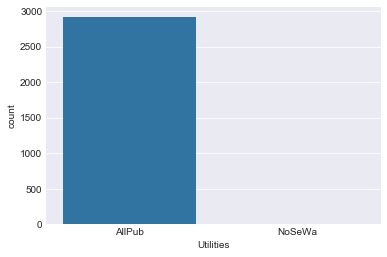

In [24]:
sns.countplot(x='Utilities',data=df_tot)
df_tot.loc[df_tot.Utilities.isnull(),'Utilities'] = 'AllPub'
print('Missing vals for Utilities fixed.')

For the missing *SaleType* entries, a histogram shows that most but not all houses were conventional warranty deed. We set the missing values equal to the mode of those houses in the same neighborhood.

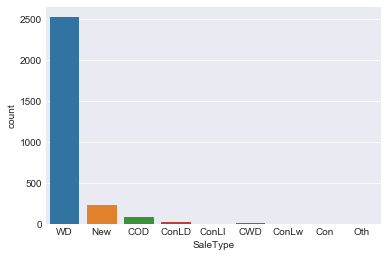

Missing vals for SaleType fixed.


In [25]:
sns.countplot(x='SaleType',data=df_tot)
plt.show()

for tmp_ind in df_tot.loc[df_tot.SaleType.isnull()].index:
    df_tot.loc[tmp_ind,'SaleType'] = df_tot.loc[df_tot.Neighborhood == df_tot.loc[tmp_ind,'Neighborhood'],'SaleType'].mode()[0]

print('Missing vals for SaleType fixed.')

For the missing *KitchenQual* value we look at those houses with the *same OverallQual*

Missing vals for KitchenQual fixed.


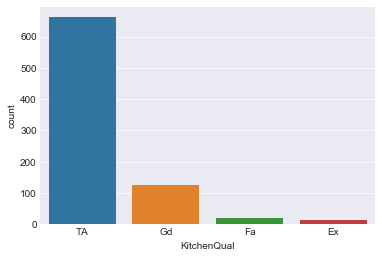

In [26]:
tmpqual = df_tot.loc[df_tot.KitchenQual.isnull(),'OverallQual'].values[0]
sns.countplot(x='KitchenQual',data=df_tot.loc[df_tot.OverallQual == tmpqual])
df_tot.loc[df_tot.KitchenQual.isnull(),'KitchenQual'] = df_tot.loc[df_tot.OverallQual == df_tot.loc[df_tot.loc[df_tot.KitchenQual.isnull()].index[0],'OverallQual'],'KitchenQual'].mode()[0]

print('Missing vals for KitchenQual fixed.')

For *Electrical*, we see that all modern houses have the same value and thus use that one.

Id
1380    2006
Name: YearBuilt, dtype: int64

Missing vals for Electrical fixed.


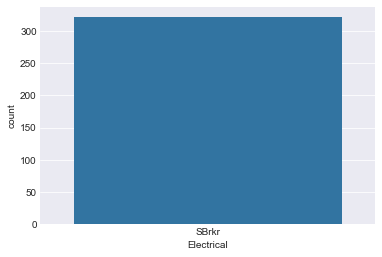

In [27]:
display(df_tot.loc[df_tot.Electrical.isnull(),'YearBuilt'])
sns.countplot(x='Electrical',data=df_tot.loc[df_tot.YearBuilt > 2005])
df_tot.loc[df_tot.Electrical.isnull(),'Electrical'] = df_tot.loc[df_tot.YearBuilt > 2005,'Electrical'].mode()[0]

print('Missing vals for Electrical fixed.')

There are a few missing values for the basement square feet describing variable. These relate to a single house that seems to have no basemend since *BsmtQual* is NotAv. We set those values to zero.

In [28]:
tmpind = df_tot.loc[df_tot.TotalBsmtSF.isnull(),['BsmtQual','BsmtCond','BsmtFinSF1','BsmtUnfSF']].index
df_tot.loc[tmpind[0],'TotalBsmtSF'] = 0
df_tot.loc[tmpind[0],'BsmtFinSF1'] = 0
df_tot.loc[tmpind[0],'BsmtFinSF2'] = 0
df_tot.loc[tmpind[0],'BsmtUnfSF'] = 0
print('Missing vals for Basement areas fixed.')

Missing vals for Basement areas fixed.


The last missing values are *Exterior1st* and *Exterior2nd*. We suppose that these are related to *RoofMatl* and the *MasVnrType* and set them to the mode of the houses with those same attributes.

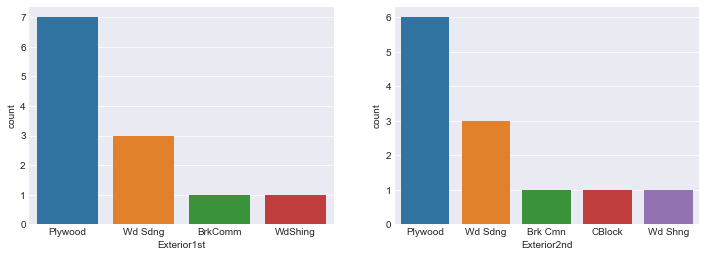

In [29]:
tmpind = df_tot.loc[df_tot.Exterior2nd.isnull(),['Exterior1st','MasVnrType','ExterQual','Foundation']].index
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,4))
sns.countplot(x='Exterior1st',data=df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.RoofMatl == df_tot.loc[tmpind[0],'RoofMatl'])],ax=ax[0])
sns.countplot(x='Exterior2nd',data=df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.RoofMatl == df_tot.loc[tmpind[0],'RoofMatl'])],ax=ax[1])
plt.show()

df_tot.loc[tmpind,'Exterior1st'] = 'Plywood'
df_tot.loc[tmpind,'Exterior2nd'] = 'Plywood'


# Feature Engineering

First, we look at the categorical features that describe qualitative attributes. We map them to properly ordered numbers.

In [30]:
from sklearn.preprocessing import LabelEncoder

Qual_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NotAv':0}
df_tot['BsmtQual'] = df_tot['BsmtQual'].map(Qual_dict)
df_tot['ExterQual'] = df_tot['ExterQual'].map(Qual_dict)
df_tot['ExterCond'] = df_tot['ExterCond'].map(Qual_dict)
df_tot['BsmtCond'] = df_tot['BsmtCond'].map(Qual_dict)
df_tot['HeatingQC'] = df_tot['HeatingQC'].map(Qual_dict)
df_tot['KitchenQual'] = df_tot['KitchenQual'].map(Qual_dict)
df_tot['FireplaceQu'] = df_tot['FireplaceQu'].map(Qual_dict)
df_tot['GarageQual'] = df_tot['GarageQual'].map(Qual_dict)
df_tot['GarageCond'] = df_tot['GarageCond'].map(Qual_dict)
df_tot['PoolQC'] = df_tot['PoolQC'].map(Qual_dict)
#
BsmtFinType1_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NotAv':0}
df_tot['BsmtFinType1'] = df_tot['BsmtFinType1'].map(BsmtFinType1_dict)
df_tot['BsmtFinType2'] = df_tot['BsmtFinType2'].map(BsmtFinType1_dict)




Next, we introduce two few new features: 
1. *AgeBuilt = YrSold - YearBuilt*
2. *AgeRemodAdd =  df_tot.YrSold - df_tot.YearRemodAdd*
3. *AgeGarage =  df_tot.YrSold - df_tot.GarageYrBlt*
4. *TotalIndrSF =  df_tot.TotalBsmtSF + df_tot.GrLivArea*

In [31]:
df_tot['AgeBuilt'] =  df_tot.YrSold - df_tot.YearBuilt
#df_tot['AgeRemodAdd'] =  df_tot.YrSold - df_tot.YearRemodAdd
#df_tot['AgeGarage'] =  df_tot.YrSold - df_tot.GarageYrBlt
df_tot['TotalIndrSF'] =  df_tot.TotalBsmtSF + df_tot.GrLivArea

Since *MSSubClass* has numerical entries without numerical meaning, we transform this into strings.

In [32]:
df_tot['MSSubClass'] = df_tot.MSSubClass.apply(str)


Last, we perform onehot encoding of the categorical variables. We then split the data set into training and test set and create a target variable from the logarithmic *SalePrice*.

In [33]:
df_tot_onehot = pd.get_dummies(df_tot)
df_train_processed = df_tot_onehot.iloc[:len(df_train),:]
df_test_processed = df_tot_onehot.iloc[len(df_train):,:]
y_target =  np.log(df_raw.SalePrice)

In [34]:
display(df_train_processed.describe())

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,70.256779,10448.784341,6.088599,5.576236,1971.18544,1984.819368,101.899038,3.392170,3.083791,3.48489,...,0.003434,0.082418,0.002060,0.868819,0.068681,0.002747,0.008242,0.013736,0.822115,0.084478
std,23.873988,9860.763449,1.369669,1.113966,30.20159,20.652143,177.113667,0.570206,0.351509,0.87409,...,0.058520,0.275094,0.045361,0.337715,0.252998,0.052360,0.090440,0.116434,0.382547,0.278199
min,21.000000,1300.000000,1.000000,1.000000,1872.00000,1950.000000,0.000000,2.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7538.750000,5.000000,5.000000,1954.00000,1966.750000,0.000000,3.000000,3.000000,3.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,70.000000,9468.500000,6.000000,5.000000,1972.00000,1993.500000,0.000000,3.000000,3.000000,4.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,80.000000,11588.000000,7.000000,6.000000,2000.00000,2004.000000,164.250000,4.000000,3.000000,4.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,5.000000,5.000000,5.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training a Basic Random Forest

We now train a random forest in order to get a baseline score of a simple regressor and to get insight about which features are important. First, we split the data into a training and validation set and define a function to compute the RMSE.

In [35]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
X_train, X_val = split_vals(df_train_processed,1-round(len(df_train_processed)/10))
y_train, y_val = split_vals(y_target,1-round(len(df_train_processed)/10))

def get_rmse(x,y):
    """Compute RMSE for numerical inputs."""
    return np.sqrt( np.sum( (x-y)**2)/len(y))

Now we train a random forest regressor. We determined the parameters with a bit of trial and error since we're only looking for a reasonable but not yet a great model. The RMSE score would put us at about the middle of the leaderboard, so it's not a terrible model.

In [36]:
rf_reg = RandomForestRegressor(n_jobs=-1, n_estimators=1000,max_features=0.5,min_samples_leaf=3, oob_score=True)
rf_reg.fit(X_train,y_train)
print('r2 score: {:4f}'.format(rf_reg.score(X_val,y_val)))
print('RMSE: {:4f}'.format(get_rmse(rf_reg.predict(X_val),y_val)))

r2 score: 0.870657
RMSE: 0.144769


# Feature Importance

In this section, we explore the importance of the different features in the leaderboard. To do this, we use the function *rf_feat_importance* from the fastai module. This function randomly shuffles one column at a time and determines how the prediction performance degrades. The idea is that the more the performance degrades for a given feature, the more important it is. This is explained [here](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-3-fa4065d8cb1e).

We see (perhaps unsurprisingly) that the most important features are the overall quality, the size, and the age of the house. A plot of all and of the 30 most important features further shows that the importance quickly degrades.

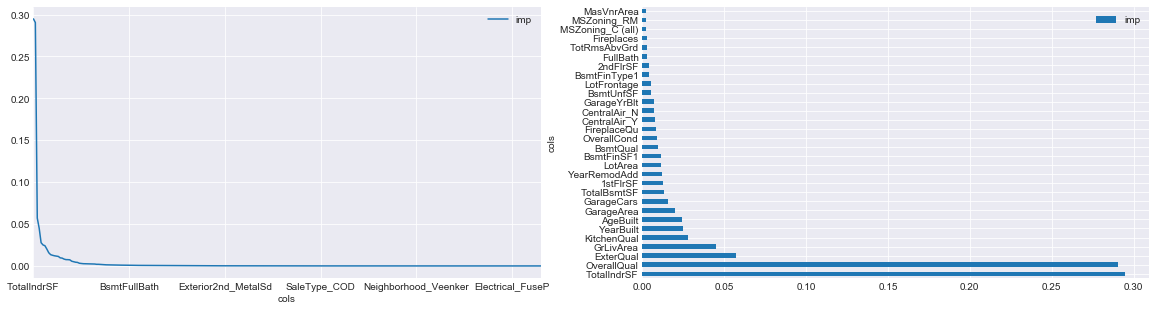

In [37]:
fi = fastaimisc.rf_feat_importance(rf_reg,X_train); fi[:10]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fi.plot('cols','imp',ax=ax[0])
fi[:30].plot('cols','imp','barh',ax=ax[1])
plt.show()

We choose only the 25 (by this measure) most important features and train a new random forest and see that the performance actually improves.

In [38]:
# determine features to keep
imp_minval = min(fi.imp.sort_values(ascending=False).head(25))
to_keep_RF = fi[fi.imp>=imp_minval].cols; print('Number of features kept: ',len(to_keep_RF))
df_keep_RF = df_train_processed[to_keep_RF].copy()
X_train_keep_RF,X_val_keep_RF = split_vals(df_keep_RF,1-round(len(df_keep_RF)/10))

rf_reduced = RandomForestRegressor(n_jobs=-1, n_estimators=1000,max_features=0.5,min_samples_leaf=3, oob_score=True)
rf_reduced.fit(X_train_keep_RF,y_train)
print('All features r2 score: {:4f}'.format(rf_reg.score(X_val,y_val)))
print('All features RMSE: {:4f}'.format(get_rmse(rf_reg.predict(X_val),y_val)))
print('Reduced features r2 score: {:4f}'.format(rf_reduced.score(X_val_keep_RF,y_val)))
print('Reduced features RMSE: {:4f}'.format(get_rmse(rf_reduced.predict(X_val_keep_RF),y_val)))

Number of features kept:  25
All features r2 score: 0.870657
All features RMSE: 0.144769
Reduced features r2 score: 0.876855
Reduced features RMSE: 0.141258


Next, we check how the remaining features there are related to each other and whether there is any redundancy that we should take care of. Again, we follow the suggestions from the [fast.ai lectures](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-4-a536f333b20d) and construct a dendogram based on a rank correlation metric. In the dendogram, strongly correlated features will be siblings with a small horizontal distance to their parent. We see that no two features have an extremely small distance. We conclude that there are no sufficiently redundant features.

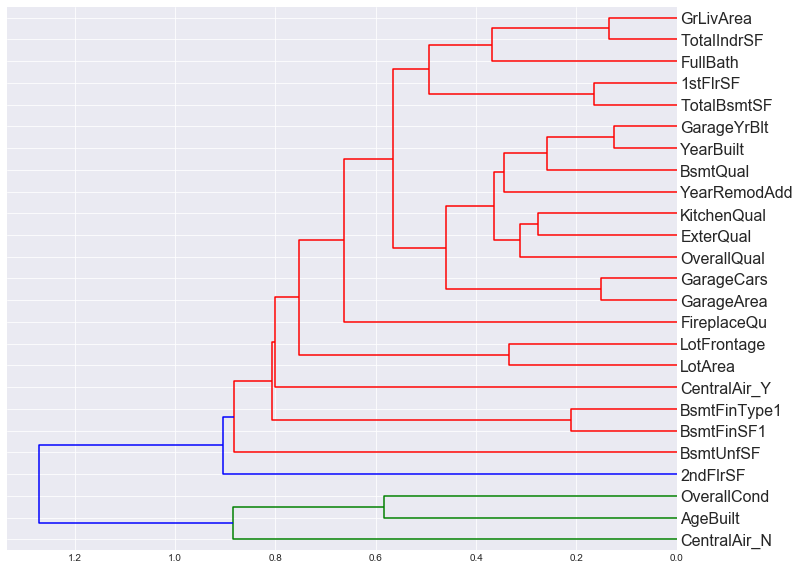

In [39]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train_keep_RF).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(12,10))
dendrogram = hc.dendrogram(z, labels=X_train_keep_RF.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

#fig,ax = plt.subplots(figsize=(8,7))
#sns.heatmap(X_train_keep_RF.corr())
#plt.show()

# XGBoost

Moving from random forests, we choose to try gradient boosting machines using the XGBoost package. For now, we skip over the hyperparameter tuning and take the XGB model parameters from [this](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) Kaggle kernel. Implementing a good hyperparameter tuning procedure is planned for future work.
We see that on our validation set, the score XGBoost score is significantly better than for the random forest. Further, we observe again that the using a reduced number of features benefits the model performance.

In [40]:
# XGBoost
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(colsample_bytree = 0.4603, min_child_weight =1.71,
                          learning_rate = 0.05, reg_lambda = .85, subsample=0.52,
                          gamma = 0.046, max_depth = 3, n_estimators = 2200)

xgb_reduced = xgb.XGBRegressor(colsample_bytree = 0.4603, min_child_weight =1.71,
                          learning_rate = 0.05, reg_lambda = .85, subsample=0.52,
                          gamma = 0.046, max_depth = 3, n_estimators = 2200)

xgb_reg.fit(X_train,y_train)
xgb_reduced.fit(X_train_keep_RF,y_train)
print('RMSE all features: {:.4f}'.format(get_rmse(xgb_reg.predict(X_val),y_val)))
print('RMSE reduced: {:.4f}'.format(get_rmse(xgb_reduced.predict(X_val_keep_RF),y_val)))

[20:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE all features: 0.1312
RMSE reduced: 0.1351


# Neural Network

As a second regressor for our predictions, we choose a simple feedforward neural network implemented in PyTorch.

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(2);

Since the scaling of the numerical values actually matters for NNs (as compared to decision trees), we copy the training and validation sets so that we can process them appropriately.

In [42]:
# create the dataset for our NN
to_keep_NN = fi[fi.imp >= imp_minval].cols;
df_NN = df_tot_onehot[to_keep_NN].copy(); display(df_NN)
print('Data sets for NN created.')

,TotalIndrSF,OverallQual,ExterQual,GrLivArea,KitchenQual,YearBuilt,AgeBuilt,GarageArea,GarageCars,TotalBsmtSF,...,OverallCond,FireplaceQu,CentralAir_Y,CentralAir_N,GarageYrBlt,BsmtUnfSF,LotFrontage,BsmtFinType1,2ndFlrSF,FullBath
Id,,,,,,,,,,,,,,,,,,,,,
1,2566.0,7,4,1710,4,2003,5,548.0,2.0,856.0,...,5,0,1,0,2003.0,150.0,65.0,6,854,2
2,2524.0,6,3,1262,3,1976,31,460.0,2.0,1262.0,...,8,3,1,0,1976.0,284.0,80.0,5,0,2
3,2706.0,7,4,1786,4,2001,7,608.0,2.0,920.0,...,5,3,1,0,2001.0,434.0,68.0,6,866,2
4,2473.0,7,3,1717,4,1915,91,642.0,3.0,756.0,...,5,4,1,0,1998.0,540.0,60.0,5,756,1
5,3343.0,8,4,2198,4,2000,8,836.0,3.0,1145.0,...,5,3,1,0,2000.0,490.0,84.0,6,1053,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1638.0,4,3,1092,3,1970,36,0.0,0.0,546.0,...,7,0,1,0,0.0,546.0,21.0,1,546,1
2916,1638.0,4,3,1092,3,1970,36,286.0,1.0,546.0,...,5,0,1,0,1970.0,294.0,21.0,3,546,1
2917,2448.0,5,3,1224,3,1960,46,576.0,2.0,1224.0,...,7,3,1,0,1960.0,0.0,160.0,5,0,1


Data sets for NN created.


To properly normalize the data, we first take a look at the distribution of our 25 features (shown are only the nonzero elements). The features related to areal sizes (such as *GrLivArea* or *TotalIndrSF*) look fairly skewed. We thus decided to transform the into the logarithmic domain. Since they are all either zero or > 1, we keep the zeros as they are (since log(0)=-inf) and still preserve the order. The remaining features are not transformed.
After applying (or not applying) the logarithm, we center all features and scale them to unit variance.

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


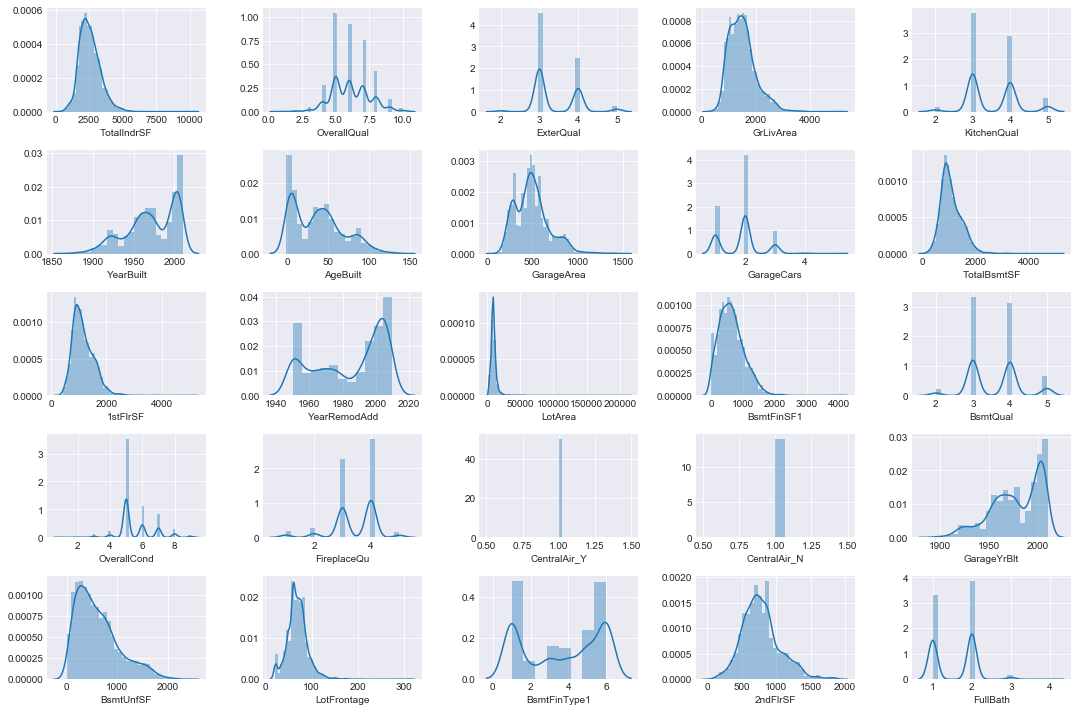

In [43]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,10))

for i, var in enumerate(df_NN):
    active_ax = ax.flatten()[i]
    sns.distplot(df_NN.loc[df_NN[var] != 0, var], ax=active_ax)
#    sns.distplot(df_NN[var], ax=active_ax)

fig.tight_layout()

In [44]:
# Define normailzation functions
def log_normalize(df):
    df[df!=0] = np.log(df[df!=0])
    return (df - np.mean(df)) / np.std(df)

def lin_normalize(df):
    return (df - np.mean(df)) / np.std(df)

# List of features to be transformed to logarithmic domain
list_lognorm = ['LotArea','MasVnrArea','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'PoolArea', 'TotalIndrSF']

# Perform normalization
for (col,data) in df_NN.iteritems():
    if col in list_lognorm:
        df_NN[col] = log_normalize(df_NN[col])
    else:
        df_NN[col] = lin_normalize(df_NN[col])

print('Features transformed and normalized.')        

Features transformed and normalized.


A second look at the distributions after normalization shows that the areal features look more 'normal' now.

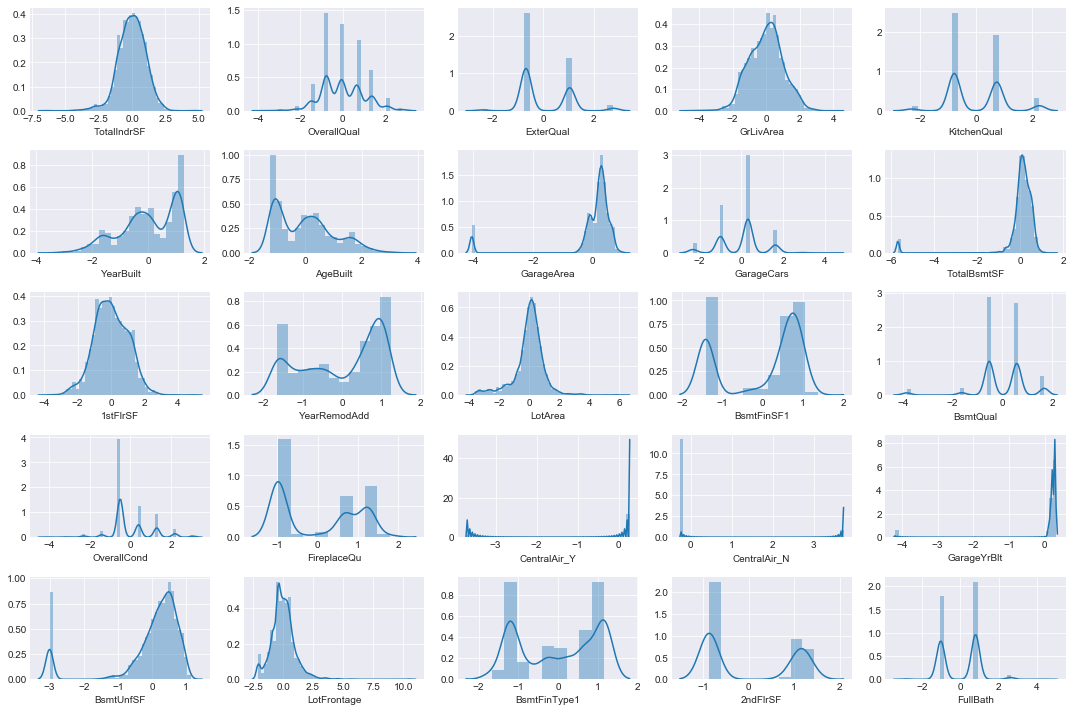

In [45]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,10))

for i, var in enumerate(df_NN):
    active_ax = ax.flatten()[i]
    #sns.distplot(df_NN.loc[df_NN[var] > 0, var], ax=active_ax)
    sns.distplot(df_NN[var], ax=active_ax)

fig.tight_layout()

We can now separated the data set into training and test set and create a test and validation set for optimizing the model.

In [46]:
df_train_NN = df_NN.iloc[:len(df_train),:]
df_test_NN = df_NN.iloc[len(df_train):,:]
y_target =  np.log(df_raw.SalePrice)
y_mean = y_target.mean()
y_std = y_target.std()
y_target_NN = (y_target-y_mean) / y_std

# Create test and validation set
X_train_NN, X_val_NN = split_vals(df_train_NN,1-round(len(df_train_NN)/10))
y_train_NN, y_val_NN = split_vals(y_target_NN,1-round(len(df_train_NN)/10))

# Create test and validation set in PyTorch
y_tensor = torch.from_numpy(np.array(y_train_NN)).float()
x_tensor = torch.from_numpy(np.array(X_train_NN)).float()
n_inputs = x_tensor.shape[1]
dataset = torch.utils.data.TensorDataset(x_tensor,y_tensor)
dataloader_NN = torch.utils.data.DataLoader(dataset,batch_size = x_tensor.size()[0])

y_tensor_val = torch.from_numpy(np.array(y_val_NN)).float()
x_tensor_val = torch.from_numpy(np.array(X_val_NN)).float()

print('Training and validation set created for PyTorch models.')

Training and validation set created for PyTorch models.


Next, we define our neural network, loss function and training routine. 

In [47]:
class Net(nn.Module):
    # initialize the network and define all learnable parameters
    def __init__(self):
        super(Net, self).__init__() # initialize properties and methods from parent class
        
        ###### add layers here ######
        self.h1  = nn.Linear(n_inputs,50, bias=True)
        self.h2  = nn.Linear(50,35, bias=True)
        self.h3  = nn.Linear(35,20, bias=True)
        self.h4 = nn.Linear(20, 10, bias=True)
        self.out = nn.Linear(10, 1, bias=True)        
        #############################
        
    # define the forward pass
    def forward(self, x):
        
        ###### code the forward computation ########
        x = F.relu(self.h1(x)) # First hidden layer
        x = F.relu(self.h2(x)) # Second hidden layer
        x = F.relu(self.h3(x))
        x = F.relu(self.h4(x))        
        out = self.out(x) # Output layer
        #############################
        return out

# create a function (this my favorite choice)
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat.view(-1)-y)**2))

def train(NeuralNetwork,dataloader,loss_function, num_epochs, l_rate=0.001, wd=0,earlystop = True ):
    """
    Performs gradient descent learning.
    
    NeuralNetwork = neural network to be trained
    dataloader = DataLoader that deals batches for mini-batch learning
    loss_function = cost function to be optimized
    num_epochs = number of training epochs
    l_rate = learning rate (default value 0.001)
    wd = weight decay regularization (default value 0)
    earlystop = training stops if error on validation set increases (computed with global variables)
    """
    optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr = l_rate)
    validation_loss = math.inf
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx , (inputs,labels) in enumerate(dataloader):
            # reset gradient
            optimizer.zero_grad()
            # forward propagation
            outputs = NeuralNetwork(inputs)
            # compute loss
            loss = torch.sqrt(loss_function(outputs, labels))
            # backprop
            loss.backward()
            # update parameters
            optimizer.step()
            # add loss
            running_loss += loss.item()
        if (epoch % 100) == 0:
            val_temp = validation_loss
            training_loss = RMSELoss(NeuralNetwork(x_tensor).detach()*y_std+y_mean,y_tensor*y_std+y_mean).numpy()
            validation_loss = RMSELoss(NeuralNetwork(x_tensor_val).detach()*y_std+y_mean,y_tensor_val*y_std+y_mean).numpy()
            print('Epoch: {0:5d} Training loss: {1:.4f}, Validation loss: {2:.4f}'.format(epoch,training_loss,validation_loss))
            if val_temp < validation_loss and earlystop:
                break

We now initialize a network and train it. We compute the error on training and validation set after every 100 epochs and stop the traing once the validation error starts to increase in order to avoid overfitting.
So far, I have only manually tweaked the model parameters and now systematic hyperparameter tuning has been performed. This will implemented in the future.

In [48]:
net_reg = Net()
print('Network initialized:',net_reg)

Network initialized: Net(
  (h1): Linear(in_features=25, out_features=50, bias=True)
  (h2): Linear(in_features=50, out_features=35, bias=True)
  (h3): Linear(in_features=35, out_features=20, bias=True)
  (h4): Linear(in_features=20, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


In [49]:
train(net_reg,dataloader_NN,RMSELoss,10000, 5*10**-5,wd=5*10**-4)

Epoch:     0 Training loss: 0.4071, Validation loss: 0.4213
Epoch:   100 Training loss: 0.3945, Validation loss: 0.4078
Epoch:   200 Training loss: 0.3593, Validation loss: 0.3682
Epoch:   300 Training loss: 0.2993, Validation loss: 0.2978
Epoch:   400 Training loss: 0.2584, Validation loss: 0.2453
Epoch:   500 Training loss: 0.2451, Validation loss: 0.2308
Epoch:   600 Training loss: 0.2350, Validation loss: 0.2214
Epoch:   700 Training loss: 0.2228, Validation loss: 0.2104
Epoch:   800 Training loss: 0.2033, Validation loss: 0.1926
Epoch:   900 Training loss: 0.1747, Validation loss: 0.1682
Epoch:  1000 Training loss: 0.1439, Validation loss: 0.1472
Epoch:  1100 Training loss: 0.1276, Validation loss: 0.1410
Epoch:  1200 Training loss: 0.1210, Validation loss: 0.1391
Epoch:  1300 Training loss: 0.1170, Validation loss: 0.1374
Epoch:  1400 Training loss: 0.1144, Validation loss: 0.1369
Epoch:  1500 Training loss: 0.1123, Validation loss: 0.1366
Epoch:  1600 Training loss: 0.1105, Vali

# Lasso

We add a Lasso model as a third regressor. Interestingly, this is as good as the neural network.

In [50]:
df_Lasso = df_tot_onehot.copy(); #display(df_Lasso)
# List of features to be transformed to logarithmic domain
list_lognorm = ['LotArea','MasVnrArea','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'PoolArea', 'TotalIndrSF']

# Perform normalization
for (col,data) in df_Lasso.iteritems():
    if col in list_lognorm:
        df_Lasso[col] = log_normalize(df_Lasso[col])
    else:
        df_Lasso[col] = lin_normalize(df_Lasso[col])

df_train_Lasso = df_Lasso.iloc[:len(df_train),:]
df_test_Lasso = df_Lasso.iloc[len(df_train):,:]
y_target =  np.log(df_raw.SalePrice)
y_mean = y_target.mean()
y_std = y_target.std()
y_target_Lasso = (y_target-y_mean) / y_std        
        
X_train_Lasso, X_val_Lasso = split_vals(df_train_Lasso,1-round(len(df_train_Lasso)/10))
y_train_Lasso, y_val_Lasso = split_vals(y_target_Lasso,1-round(len(df_train_Lasso)/10))        
print('Features transformed and normalized.')  

Features transformed and normalized.


In [51]:
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=10**-4)
lasso_reg.fit(X_train_Lasso,y_train_Lasso)
print('Lasso validation RMSE: {:4f}'.format(get_rmse(lasso_reg.predict(X_val_Lasso)*y_std+y_mean,y_val_Lasso*y_std+y_mean)))

Lasso validation RMSE: 0.130564


# Combining the models

Now that we have three models, we need either choose one or combine them in a suitable manner. Since all three models are themselves reasonably good predictors and achieve RMSEs on the same scale, we hope to profit from averaging the models to also average (and reduce) the resulting prediction errors.

In [52]:
# Create the predictions
pred_NN = net_reg(x_tensor_val).detach().numpy().flatten()*y_std+y_mean
pred_Lasso = lasso_reg.predict(X_val_Lasso)*y_std+y_mean
pred_XGB = xgb_reg.predict(X_val)

A scatterplot of the predictions for validation set shows that the three models certainly make different predictions. 

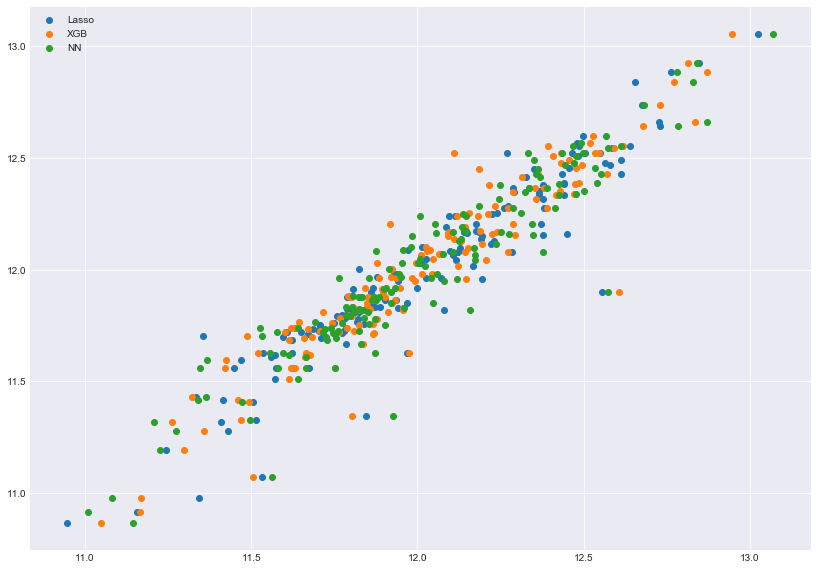

In [53]:
fig, ax = plt.subplots(figsize=(14,10))
ax.scatter(pred_Lasso,y_val)
ax.scatter(pred_XGB,y_val)
ax.scatter(pred_NN,y_val)
ax.legend(['Lasso','XGB','NN'])
plt.show()

To find the best weights, we simple sample a fine grid of weights between zero and one for each model and combine the models with theses weights. The result can be visualized nicely. An interesting observation (not shown) is that while the XGB model with a reduced number of features is better than the full model, in combination with Lasso and NN it is beneficial to use the full model. We will thus use XGB will all features in the final model.
We see that the combined model has a significantly lower RMSE than the individual ones. We save those weights for the final model.

Observation: running this experiments several times, it seems clear that the statistical variations are too large to ensure a reasonable estimate of the weights. A way to tackle this problem could be cross validation, i.e., training multiple models on different training/validation sets. Without a stable estimate of the weights, we just set them to 1/3 each.

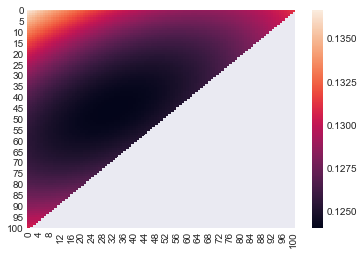

Best RMSE:0.124063
Estimated mixture weights: Lasso 0.460000, XGBoost 0.320000, NN 0.220000
Weights set to 1/3 each.


In [54]:
pred_NN = net_reg(x_tensor_val).detach().numpy().flatten()*y_std+y_mean
pred_Lasso = lasso_reg.predict(X_val_Lasso)*y_std+y_mean
pred_XGB = xgb_reg.predict(X_val)
grid = np.linspace(0,1,101)
err_mixed = np.nan*np.ones((len(grid),len(grid)))
idx1 = 0 
minval = 10
for w_Lasso in grid:
    idx2 = 0 
    for w_XGB in grid:
        if w_Lasso + w_XGB > 1:
            break
        else:
            err_mixed[idx1,idx2] = get_rmse(pred_Lasso*w_Lasso + pred_XGB*w_XGB + (1-w_Lasso-w_XGB)*(pred_NN),y_val)
            if err_mixed[idx1,idx2] < minval:
                minval = err_mixed[idx1,idx2]
                idx1_min = idx1
                idx2_min = idx2
    #print('Weight: ', weight,' RMSE: ',((xgb_reg.predict(X_val)*weight + (1-weight)*(predictions_NN))-y_val).std())
        idx2 += 1
    idx1 += 1        

w_opt_Lasso = grid[idx1_min]
w_opt_XGB = grid[idx2_min]
w_opt_NN = 1 - w_opt_Lasso - w_opt_XGB


sns.heatmap(err_mixed)
plt.show()
print('Best RMSE:{:4f}'.format(minval))
print('Estimated mixture weights: Lasso {0:2f}, XGBoost {1:2f}, NN {2:2f}'.format(w_opt_Lasso,w_opt_XGB,w_opt_NN))
w_opt_XGB = 1/3
w_opt_Lasso = 1/3
w_opt_NN = 1/3
print('Weights set to 1/3 each.')


# Final Model

For the final model, we create the full data sets and then train Lasso, XGB and the NN with the parameters from above. We can then combine the models using the weights determined in the previous section.

### Full XGB

In [55]:
import xgboost as xgb
xg_full = xgb.XGBRegressor(colsample_bytree = 0.4603, min_child_weight = 1.71,
                          learning_rate = 0.05, reg_lambda = .85, subsample=0.52,
                          gamma = 0.046, max_depth = 3, n_estimators = 2200)
xg_full.fit(df_train_processed,y_target)

predictions_XGB_final = xg_full.predict(df_test_processed)

print('Final XGB model trained and predictions made.')

[20:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Final XGB model trained and predictions made.


### Neural Network

In [56]:

# Create full dataset
y_tensor_full = torch.from_numpy(np.array(y_target_NN)).float()
x_tensor_full = torch.from_numpy(np.array(df_train_NN)).float()
n_inputs = x_tensor_full.shape[1]
dataset_full = torch.utils.data.TensorDataset(x_tensor_full,y_tensor_full)
dataloader_NN_full = torch.utils.data.DataLoader(dataset_full,batch_size = x_tensor_full.size()[0])

# Create and train network
net_final = Net()
train(net_final,dataloader_NN_full,RMSELoss,1500, 5*10**-5,wd=5*10**-4, earlystop = False)
train(net_final,dataloader_NN_full,RMSELoss,1000, 5*10**-6,wd=5*10**-4, earlystop = False)

# make predictions
x_tensor_test = torch.from_numpy(np.array(df_test_NN)).float()
predictions_NN_final = net_reg(x_tensor_test).detach().numpy().flatten()*y_std+y_mean

print('Final NN trained and predictions made.')

Epoch:     0 Training loss: 0.4017, Validation loss: 0.4145
Epoch:   100 Training loss: 0.3939, Validation loss: 0.4055
Epoch:   200 Training loss: 0.3757, Validation loss: 0.3845
Epoch:   300 Training loss: 0.3278, Validation loss: 0.3270
Epoch:   400 Training loss: 0.2712, Validation loss: 0.2572
Epoch:   500 Training loss: 0.2433, Validation loss: 0.2290
Epoch:   600 Training loss: 0.2151, Validation loss: 0.2018
Epoch:   700 Training loss: 0.1816, Validation loss: 0.1704
Epoch:   800 Training loss: 0.1501, Validation loss: 0.1435
Epoch:   900 Training loss: 0.1313, Validation loss: 0.1303
Epoch:  1000 Training loss: 0.1226, Validation loss: 0.1245
Epoch:  1100 Training loss: 0.1180, Validation loss: 0.1213
Epoch:  1200 Training loss: 0.1150, Validation loss: 0.1193
Epoch:  1300 Training loss: 0.1127, Validation loss: 0.1181
Epoch:  1400 Training loss: 0.1108, Validation loss: 0.1170
Epoch:     0 Training loss: 0.1091, Validation loss: 0.1158
Epoch:   100 Training loss: 0.1088, Vali

### Lasso

In [57]:
lasso_full = linear_model.Lasso(alpha=10**-4)
lasso_full.fit(df_train_Lasso,y_target_Lasso)
predictions_Lasso_final = lasso_full.predict(df_test_Lasso)*y_std+y_mean
print('Final Lasso model trained and predictions made.')

Final Lasso model trained and predictions made.


### Putting Predictions Together

For the final predictions, we add the three weighted models. Last, we take care of the outlier (the unusually large partial sale) and insert its predictions that we made at the top. 

In [58]:
predictions_total = predictions_XGB_final * w_opt_XGB + predictions_Lasso_final * w_opt_Lasso + predictions_NN_final * w_opt_NN
outlier_test_ID = df_test_processed.loc[df_test_processed.GrLivArea > 4000].index[0]
df_pred = pd.DataFrame()
df_pred.insert(0,'SalePrice',np.exp(predictions_total))
df_pred.insert(0,'Id',df_test_processed.index)
df_pred.loc[df_pred.Id == outlier_test_ID,'SalePrice'] = outlier_predicted_price
display(df_pred)
df_pred.to_csv('HousePrices.csv',index=False)

print('Predictions made, csv file saved.')

,Id,SalePrice
0,1461,122026.553238
1,1462,163367.323538
2,1463,183823.030667
3,1464,192184.286595
4,1465,192886.403225
...,...,...
1454,2915,85371.644772
1455,2916,85012.661228
1456,2917,164852.580401
1457,2918,120110.093734


Predictions made, csv file saved.
